In [ ]:
#@title
!pip install mne
%matplotlib inline



# Background information on filtering

Here we give some background information on filtering in general, and
how it is done in MNE-Python in particular.
Recommended reading for practical applications of digital
filter design can be found in Parks & Burrus (1987) [1] and
Ifeachor & Jervis (2002) [2], and for filtering in an
M/EEG context we recommend reading Widmann *et al.* (2015) [7].
To see how to use the default filters in MNE-Python on actual data, see
the `tut-filter-resample` tutorial.

## Problem statement

Practical issues with filtering electrophysiological data are covered
in Widmann *et al.* (2012) [6], where they conclude with this statement:

>Filtering can result in considerable distortions of the time course
(and amplitude) of a signal as demonstrated by VanRullen (2011) [3].
Thus, filtering should not be used lightly. However, if effects of
filtering are cautiously considered and filter artifacts are minimized,
a valid interpretation of the temporal dynamics of filtered
electrophysiological data is possible and signals missed otherwise
can be detected with filtering.

In other words, filtering can increase signal-to-noise ratio (SNR), but if it
is not used carefully, it can distort data. Here we hope to cover some
filtering basics so users can better understand filtering trade-offs and why
MNE-Python has chosen particular defaults.


## Filtering basics

Let's get some of the basic math down. In the frequency domain, digital
filters have a transfer function that is given by:

\begin{align}H(z) &= \frac{b_0 + b_1 z^{-1} + b_2 z^{-2} + \ldots + b_M z^{-M}}
                 {1 + a_1 z^{-1} + a_2 z^{-2} + \ldots + a_N z^{-M}} \\
         &= \frac{\sum_{k=0}^Mb_kz^{-k}}{\sum_{k=1}^Na_kz^{-k}}\end{align}

In the time domain, the numerator coefficients $b_k$ and denominator
coefficients $a_k$ can be used to obtain our output data
$y(n)$ in terms of our input data $x(n)$ as:

\begin{align}
    y(n) &= b_0 x(n) + b_1 x(n-1) + \ldots + b_M x(n-M)
            - a_1 y(n-1) - a_2 y(n - 2) - \ldots - a_N y(n - N)\\
         &= \sum_{k=0}^M b_k x(n-k) - \sum_{k=1}^N a_k y(n-k)
\end{align}


In other words, the output at time $n$ is determined by a sum over

  1. the numerator coefficients $b_k$, which get multiplied by
      the previous input values $x(n-k)$, and
  2. the denominator coefficients $a_k$, which get multiplied by
      the previous output values $y(n-k)$.

Note that these summations correspond to (1) a weighted `moving average`_ and
(2) an autoregression_.

Filters are broken into two classes: FIR_ (finite impulse response) and
IIR_ (infinite impulse response) based on these coefficients.
FIR filters use a finite number of numerator
coefficients $b_k$ ($\forall k, a_k=0$), and thus each output
value of $y(n)$ depends only on the $M$ previous input values.
IIR filters depend on the previous input and output values, and thus can have
effectively infinite impulse responses.

As outlined in Parks & Burrus (1987) [1], FIR and IIR have different
trade-offs:

* A causal FIR filter can be linear-phase -- i.e., the same time delay
  across all frequencies -- whereas a causal IIR filter cannot. The phase
  and group delay characteristics are also usually better for FIR filters.
* IIR filters can generally have a steeper cutoff than an FIR filter of
  equivalent order.
* IIR filters are generally less numerically stable, in part due to
  accumulating error (due to its recursive calculations).

In MNE-Python we default to using FIR filtering. As noted in Widmann *et al.*(2015) [7]:

  Despite IIR filters often being considered as computationally more
  efficient, they are recommended only when high throughput and sharp
  cutoffs are required (Ifeachor and Jervis, 2002 [2], p. 321)...
  FIR filters are easier to control, are always stable, have a
  well-defined passband, can be corrected to zero-phase without
  additional computations, and can be converted to minimum-phase.
  We therefore recommend FIR filters for most purposes in
  electrophysiological data analysis.

When designing a filter (FIR or IIR), there are always trade-offs that
need to be considered, including but not limited to:

1. Ripple in the pass-band
2. Attenuation of the stop-band
3. Steepness of roll-off
4. Filter order (i.e., length for FIR filters)
5. Time-domain ringing

In general, the sharper something is in frequency, the broader it is in time,
and vice-versa. This is a fundamental time-frequency trade-off, and it will
show up below.

## FIR Filters

First, we will focus on FIR filters, which are the default filters used by
MNE-Python.


### Designing FIR filters
Here we'll try to design a low-pass filter and look at trade-offs in terms
of time- and frequency-domain filter characteristics. Later, in
`tut_effect_on_signals`, we'll look at how such filters can affect
signals when they are used.

First let's import some useful tools for filtering, and set some default
values for our data that are reasonable for M/EEG.



In [ ]:
import numpy as np
from numpy.fft import fft, fftfreq
from scipy import signal
import matplotlib.pyplot as plt

from mne.time_frequency.tfr import morlet
from mne.viz import plot_filter, plot_ideal_filter

import mne

sfreq = 1000.
f_p = 40.
flim = (1., sfreq / 2.)  # limits for plotting

Take for example an ideal low-pass filter, which would give a magnitude
response of 1 in the pass-band (up to frequency $f_p$) and a magnitude
response of 0 in the stop-band (down to frequency $f_s$) such that
$f_p=f_s=40$ Hz here (shown to a lower limit of -60 dB for simplicity):



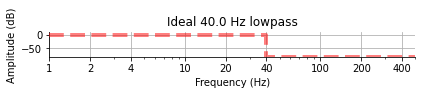

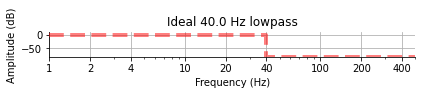

In [ ]:
nyq = sfreq / 2.  # the Nyquist frequency is half our sample rate
freq = [0, f_p, f_p, nyq]
gain = [1, 1, 0, 0]

third_height = np.array(plt.rcParams['figure.figsize']) * [1, 1. / 3.]
ax = plt.subplots(1, figsize=third_height)[1]
plot_ideal_filter(freq, gain, ax, title='Ideal %s Hz lowpass' % f_p, flim=flim)

This filter hypothetically achieves zero ripple in the frequency domain,
perfect attenuation, and perfect steepness. However, due to the discontinuity
in the frequency response, the filter would require infinite ringing in the
time domain (i.e., infinite order) to be realized. Another way to think of
this is that a rectangular window in the frequency domain is actually a sinc_
function in the time domain, which requires an infinite number of samples
(and thus infinite time) to represent. So although this filter has ideal
frequency suppression, it has poor time-domain characteristics.

Let's try to naïvely make a brick-wall filter of length 0.1 s, and look
at the filter itself in the time domain and the frequency domain:



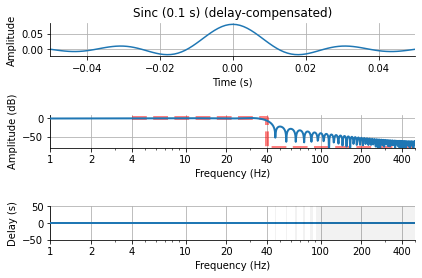

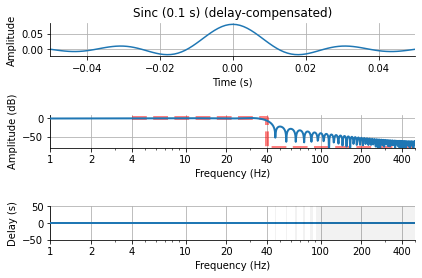

In [ ]:
n = int(round(0.1 * sfreq))
n -= n % 2 - 1  # make it odd
t = np.arange(-(n // 2), n // 2 + 1) / sfreq  # center our sinc
h = np.sinc(2 * f_p * t) / (4 * np.pi)
plot_filter(h, sfreq, freq, gain, 'Sinc (0.1 s)', flim=flim, compensate=True)

This is not so good! Making the filter 10 times longer (1 s) gets us a
slightly better stop-band suppression, but still has a lot of ringing in
the time domain. Note the x-axis is an order of magnitude longer here,
and the filter has a correspondingly much longer group delay (again equal
to half the filter length, or 0.5 seconds):



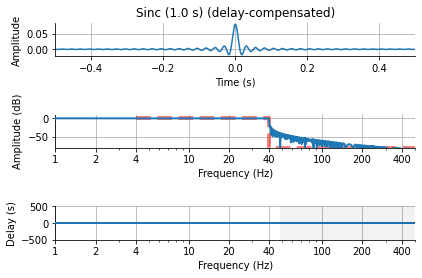

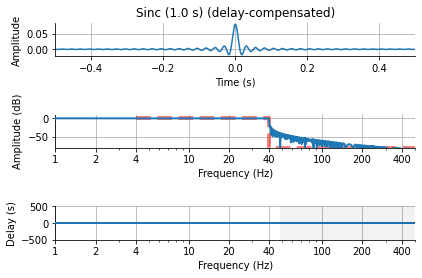

In [ ]:
n = int(round(1. * sfreq))
n -= n % 2 - 1  # make it odd
t = np.arange(-(n // 2), n // 2 + 1) / sfreq
h = np.sinc(2 * f_p * t) / (4 * np.pi)
plot_filter(h, sfreq, freq, gain, 'Sinc (1.0 s)', flim=flim, compensate=True)

Let's make the stop-band tighter still with a longer filter (10 s),
with a resulting larger x-axis:



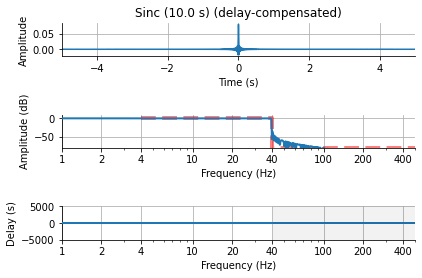

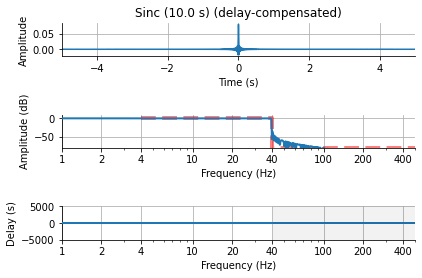

In [ ]:
n = int(round(10. * sfreq))
n -= n % 2 - 1  # make it odd
t = np.arange(-(n // 2), n // 2 + 1) / sfreq
h = np.sinc(2 * f_p * t) / (4 * np.pi)
plot_filter(h, sfreq, freq, gain, 'Sinc (10.0 s)', flim=flim, compensate=True)

Now we have very sharp frequency suppression, but our filter rings for the
entire 10 seconds. So this naïve method is probably not a good way to build
our low-pass filter.

Fortunately, there are multiple established methods to design FIR filters
based on desired response characteristics. These include:

    1. The Remez_ algorithm (:func:`scipy.signal.remez`, `MATLAB firpm`_)
    2. Windowed FIR design (:func:`scipy.signal.firwin2`,
       :func:`scipy.signal.firwin`, and `MATLAB fir2`_)
    3. Least squares designs (:func:`scipy.signal.firls`, `MATLAB firls`_)
    4. Frequency-domain design (construct filter in Fourier
       domain and use an :func:`IFFT <numpy.fft.ifft>` to invert it)

<div class="alert alert-info"><h4>Note</h4><p>Remez and least squares designs have advantages when there are
          "do not care" regions in our frequency response. However, we want
          well controlled responses in all frequency regions.
          Frequency-domain construction is good when an arbitrary response
          is desired, but generally less clean (due to sampling issues) than
          a windowed approach for more straightforward filter applications.
          Since our filters (low-pass, high-pass, band-pass, band-stop)
          are fairly simple and we require precise control of all frequency
          regions, we will primarily use and explore windowed FIR design.</p></div>

If we relax our frequency-domain filter requirements a little bit, we can
use these functions to construct a lowpass filter that instead has a
*transition band*, or a region between the pass frequency $f_p$
and stop frequency $f_s$, e.g.:



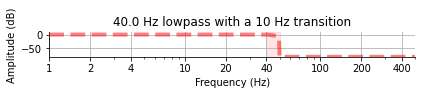

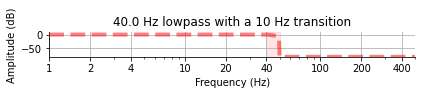

In [ ]:
trans_bandwidth = 10  # 10 Hz transition band
f_s = f_p + trans_bandwidth  # = 50 Hz

freq = [0., f_p, f_s, nyq]
gain = [1., 1., 0., 0.]
ax = plt.subplots(1, figsize=third_height)[1]
title = '%s Hz lowpass with a %s Hz transition' % (f_p, trans_bandwidth)
plot_ideal_filter(freq, gain, ax, title=title, flim=flim)

Accepting a shallower roll-off of the filter in the frequency domain makes
our time-domain response potentially much better. We end up with a more
gradual slope through the transition region, but a *much* cleaner time
domain signal. Here again for the 1 s filter:



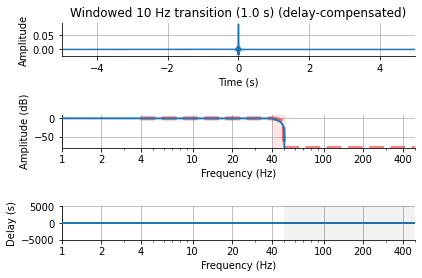

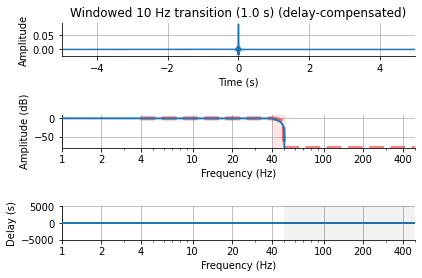

In [ ]:
h = signal.firwin2(n, freq, gain, nyq=nyq)
plot_filter(h, sfreq, freq, gain, 'Windowed 10 Hz transition (1.0 s)',
            flim=flim, compensate=True)

Since our lowpass is around 40 Hz with a 10 Hz transition, we can actually
use a shorter filter (5 cycles at 10 Hz = 0.5 s) and still get acceptable
stop-band attenuation:



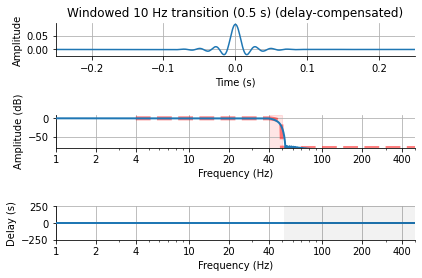

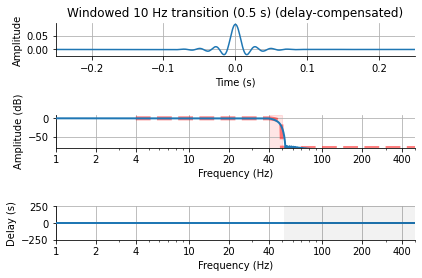

In [ ]:
n = int(round(sfreq * 0.5)) + 1
h = signal.firwin2(n, freq, gain, nyq=nyq)
plot_filter(h, sfreq, freq, gain, 'Windowed 10 Hz transition (0.5 s)',
            flim=flim, compensate=True)

But if we shorten the filter too much (2 cycles of 10 Hz = 0.2 s),
our effective stop frequency gets pushed out past 60 Hz:



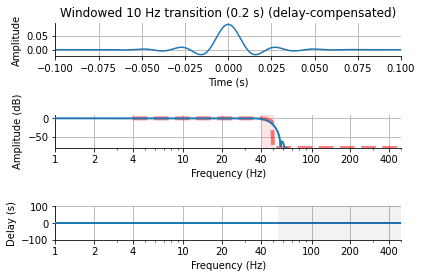

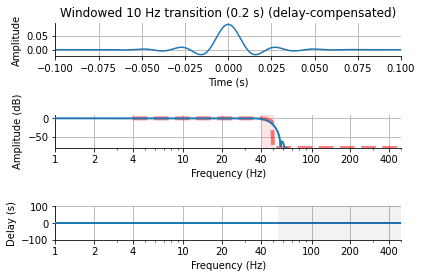

In [ ]:
n = int(round(sfreq * 0.2)) + 1
h = signal.firwin2(n, freq, gain, nyq=nyq)
plot_filter(h, sfreq, freq, gain, 'Windowed 10 Hz transition (0.2 s)',
            flim=flim, compensate=True)

If we want a filter that is only 0.1 seconds long, we should probably use
something more like a 25 Hz transition band (0.2 s = 5 cycles @ 25 Hz):



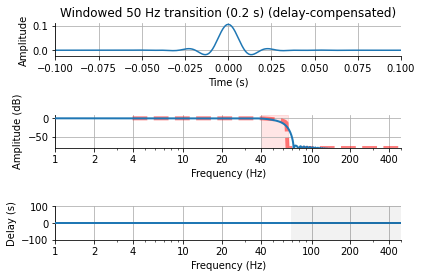

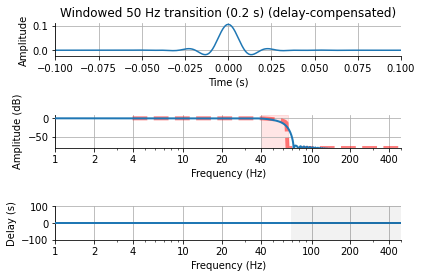

In [ ]:
trans_bandwidth = 25
f_s = f_p + trans_bandwidth
freq = [0, f_p, f_s, nyq]
h = signal.firwin2(n, freq, gain, nyq=nyq)
plot_filter(h, sfreq, freq, gain, 'Windowed 50 Hz transition (0.2 s)',
            flim=flim, compensate=True)

So far, we have only discussed *non-causal* filtering, which means that each
sample at each time point $t$ is filtered using samples that come
after ($t + \Delta t$) *and* before ($t - \Delta t$) the current
time point $t$.
In this sense, each sample is influenced by samples that come both before
and after it. This is useful in many cases, especially because it does not
delay the timing of events.

However, sometimes it can be beneficial to use *causal* filtering,
whereby each sample $t$ is filtered only using time points that came
after it.

Note that the delay is variable (whereas for linear/zero-phase filters it
is constant) but small in the pass-band. Unlike zero-phase filters, which
require time-shifting backward the output of a linear-phase filtering stage
(and thus becoming non-causal), minimum-phase filters do not require any
compensation to achieve small delays in the pass-band. Note that as an
artifact of the minimum phase filter construction step, the filter does
not end up being as steep as the linear/zero-phase version.

We can construct a minimum-phase filter from our existing linear-phase
filter with the :func:`scipy.signal.minimum_phase` function, and note
that the falloff is not as steep:



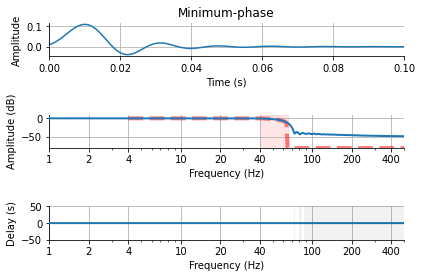

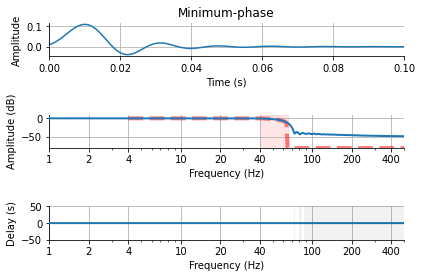

In [ ]:
h_min = signal.minimum_phase(h)
plot_filter(h_min, sfreq, freq, gain, 'Minimum-phase', flim=flim)


### Applying FIR filters

Now lets look at some practical effects of these filters by applying
them to some data.

Let's construct a Gaussian-windowed sinusoid (i.e., Morlet imaginary part)
plus noise (random and line). Note that the original clean signal contains
frequency content in both the pass band and transition bands of our
low-pass filter.



In [ ]:
dur = 10.
center = 2.
morlet_freq = f_p
tlim = [center - 0.2, center + 0.2]
tticks = [tlim[0], center, tlim[1]]
flim = [20, 70]

x = np.zeros(int(sfreq * dur) + 1)
blip = morlet(sfreq, [morlet_freq], n_cycles=7)[0].imag / 20.
n_onset = int(center * sfreq) - len(blip) // 2
x[n_onset:n_onset + len(blip)] += blip
x_orig = x.copy()

rng = np.random.RandomState(0)
x += rng.randn(len(x)) / 1000.
x += np.sin(2. * np.pi * 60. * np.arange(len(x)) / sfreq) / 2000.

Filter it with a shallow cutoff, linear-phase FIR (which allows us to
compensate for the constant filter delay):



Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)



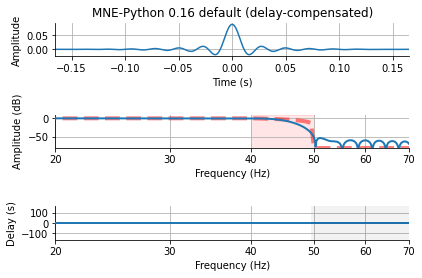

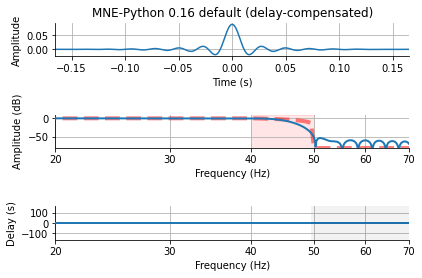

In [ ]:
transition_band = 0.25 * f_p
f_s = f_p + transition_band
freq = [0., f_p, f_s, sfreq / 2.]
gain = [1., 1., 0., 0.]
# This would be equivalent:
h = mne.filter.create_filter(x, sfreq, l_freq=None, h_freq=f_p,
                             fir_design='firwin', verbose=True)
x_v16 = np.convolve(h, x)
# this is the linear->zero phase, causal-to-non-causal conversion / shift
x_v16 = x_v16[len(h) // 2:]

plot_filter(h, sfreq, freq, gain, 'MNE-Python 0.16 default', flim=flim,
            compensate=True)

Filter it with a different design method ``fir_design="firwin2"``, and also
compensate for the constant filter delay. This method does not produce
quite as sharp a transition compared to ``fir_design="firwin"``, despite
being twice as long:



Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (0.661 sec)



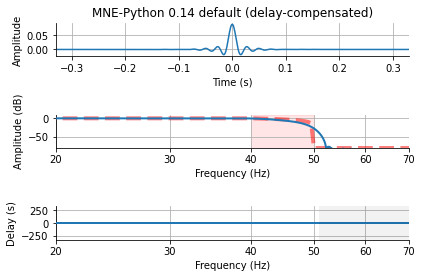

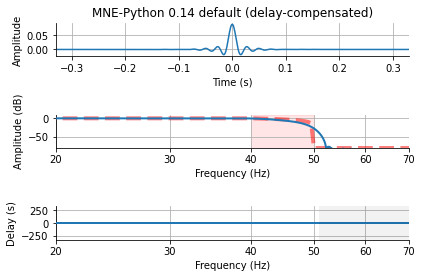

In [ ]:
transition_band = 0.25 * f_p
f_s = f_p + transition_band
freq = [0., f_p, f_s, sfreq / 2.]
gain = [1., 1., 0., 0.]
# This would be equivalent:
# filter_dur = 6.6 / transition_band  # sec
# n = int(sfreq * filter_dur)
# h = signal.firwin2(n, freq, gain, nyq=sfreq / 2.)
h = mne.filter.create_filter(x, sfreq, l_freq=None, h_freq=f_p,
                             fir_design='firwin2', verbose=True)
x_v14 = np.convolve(h, x)[len(h) // 2:]

plot_filter(h, sfreq, freq, gain, 'MNE-Python 0.14 default', flim=flim,
            compensate=True)

Let's also filter with the MNE-Python 0.13 default, which is a
long-duration, steep cutoff FIR that gets applied twice:



Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 40.25 Hz)
- Filter length: 10001 samples (10.001 sec)



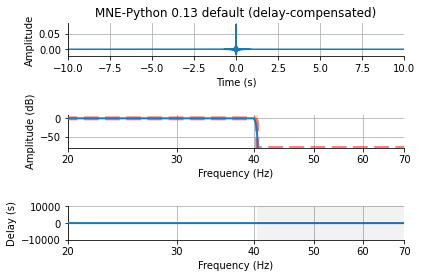

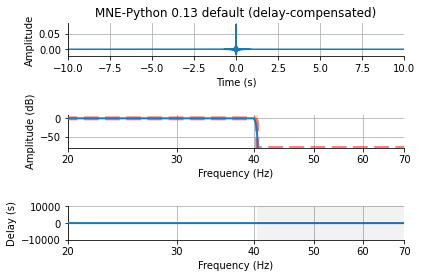

In [ ]:
transition_band = 0.5  # Hz
f_s = f_p + transition_band
filter_dur = 10.  # sec
freq = [0., f_p, f_s, sfreq / 2.]
gain = [1., 1., 0., 0.]
# This would be equivalent
# n = int(sfreq * filter_dur)
# h = signal.firwin2(n, freq, gain, nyq=sfreq / 2.)
h = mne.filter.create_filter(x, sfreq, l_freq=None, h_freq=f_p,
                             h_trans_bandwidth=transition_band,
                             filter_length='%ss' % filter_dur,
                             fir_design='firwin2', verbose=True)
x_v13 = np.convolve(np.convolve(h, x)[::-1], h)[::-1][len(h) - 1:-len(h) - 1]
# the effective h is one that is applied to the time-reversed version of itself
h_eff = np.convolve(h, h[::-1])
plot_filter(h_eff, sfreq, freq, gain, 'MNE-Python 0.13 default', flim=flim,
            compensate=True)

Let's also filter it with the MNE-C default, which is a long-duration
steep-slope FIR filter designed using frequency-domain techniques:



filter :   0.000 ...   42.5 Hz   bins : 0 ... 348 of 4097 hpw : 3 lpw : 20


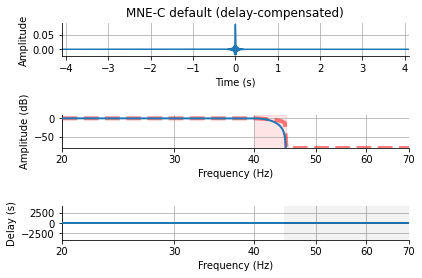

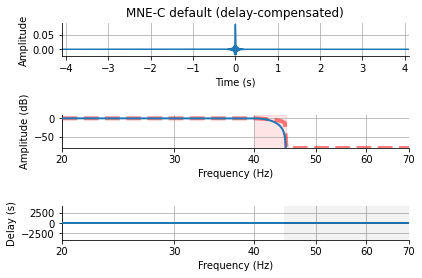

In [ ]:
h = mne.filter.design_mne_c_filter(sfreq, l_freq=None, h_freq=f_p + 2.5)
x_mne_c = np.convolve(h, x)[len(h) // 2:]

transition_band = 5  # Hz (default in MNE-C)
f_s = f_p + transition_band
freq = [0., f_p, f_s, sfreq / 2.]
gain = [1., 1., 0., 0.]
plot_filter(h, sfreq, freq, gain, 'MNE-C default', flim=flim, compensate=True)

And now an example of a minimum-phase filter:



Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, non-linear phase, causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper transition bandwidth: 10.00 Hz
- Filter length: 331 samples (0.331 sec)



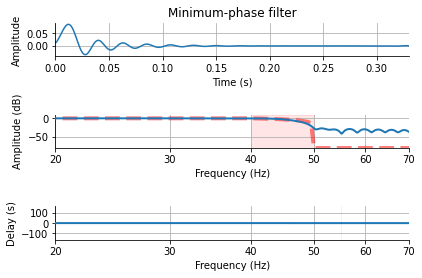

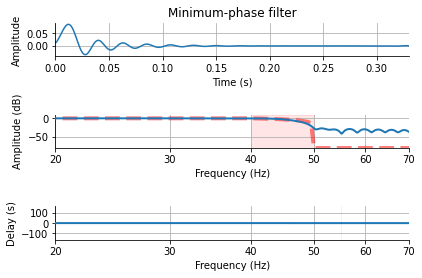

In [ ]:
h = mne.filter.create_filter(x, sfreq, l_freq=None, h_freq=f_p,
                             phase='minimum', fir_design='firwin',
                             verbose=True)
x_min = np.convolve(h, x)
transition_band = 0.25 * f_p
f_s = f_p + transition_band
filter_dur = 6.6 / transition_band  # sec
n = int(sfreq * filter_dur)
freq = [0., f_p, f_s, sfreq / 2.]
gain = [1., 1., 0., 0.]
plot_filter(h, sfreq, freq, gain, 'Minimum-phase filter', flim=flim)

Both the MNE-Python 0.13 and MNE-C filters have excellent frequency
attenuation, but it comes at a cost of potential
ringing (long-lasting ripples) in the time domain. Ringing can occur with
steep filters, especially in signals with frequency content around the
transition band. Our Morlet wavelet signal has power in our transition band,
and the time-domain ringing is thus more pronounced for the steep-slope,
long-duration filter than the shorter, shallower-slope filter:



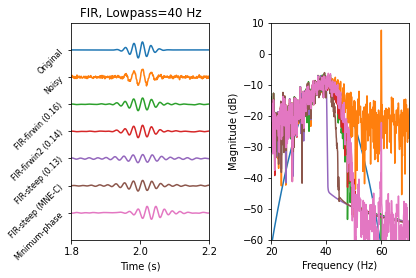

In [ ]:
axes = plt.subplots(1, 2)[1]


def plot_signal(x, offset):
    """Plot a signal."""
    t = np.arange(len(x)) / sfreq
    axes[0].plot(t, x + offset)
    axes[0].set(xlabel='Time (s)', xlim=t[[0, -1]])
    X = fft(x)
    freqs = fftfreq(len(x), 1. / sfreq)
    mask = freqs >= 0
    X = X[mask]
    freqs = freqs[mask]
    axes[1].plot(freqs, 20 * np.log10(np.maximum(np.abs(X), 1e-16)))
    axes[1].set(xlim=flim)


yscale = 30
yticklabels = ['Original', 'Noisy', 'FIR-firwin (0.16)', 'FIR-firwin2 (0.14)',
               'FIR-steep (0.13)', 'FIR-steep (MNE-C)', 'Minimum-phase']
yticks = -np.arange(len(yticklabels)) / yscale
plot_signal(x_orig, offset=yticks[0])
plot_signal(x, offset=yticks[1])
plot_signal(x_v16, offset=yticks[2])
plot_signal(x_v14, offset=yticks[3])
plot_signal(x_v13, offset=yticks[4])
plot_signal(x_mne_c, offset=yticks[5])
plot_signal(x_min, offset=yticks[6])
axes[0].set(xlim=tlim, title='FIR, Lowpass=%d Hz' % f_p, xticks=tticks,
            ylim=[-len(yticks) / yscale, 1. / yscale],
            yticks=yticks, yticklabels=yticklabels)
for text in axes[0].get_yticklabels():
    text.set(rotation=45, size=8)
axes[1].set(xlim=flim, ylim=(-60, 10), xlabel='Frequency (Hz)',
            ylabel='Magnitude (dB)')
mne.viz.tight_layout()
plt.show()

## IIR filters

MNE-Python also offers IIR filtering functionality that is based on the
methods from :mod:`scipy.signal`. Specifically, we use the general-purpose
functions :func:`scipy.signal.iirfilter` and :func:`scipy.signal.iirdesign`,
which provide unified interfaces to IIR filter design.

### Designing IIR filters

Let's continue with our design of a 40 Hz low-pass filter and look at
some trade-offs of different IIR filters.

Often the default IIR filter is a `Butterworth filter`_, which is designed
to have a *maximally flat pass-band*. Let's look at a few filter orders,
i.e., a few different number of coefficients used and therefore steepness
of the filter:

<div class="alert alert-info"><h4>Note</h4><p>Notice that the group delay (which is related to the phase) of
          the IIR filters below are not constant. In the FIR case, we can
          design so-called linear-phase filters that have a constant group
          delay, and thus compensate for the delay (making the filter
          non-causal) if necessary. This cannot be done with IIR filters, as
          they have a non-linear phase (non-constant group delay). As the
          filter order increases, the phase distortion near and in the
          transition band worsens. However, if non-causal (forward-backward)
          filtering can be used, e.g. with :func:`scipy.signal.filtfilt`,
          these phase issues can theoretically be mitigated.</p></div>



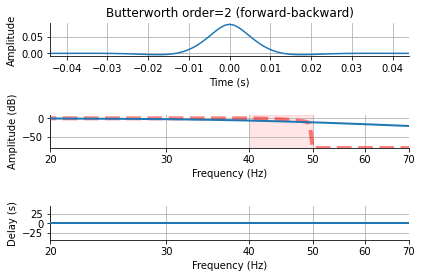

In [ ]:
sos = signal.iirfilter(2, f_p / nyq, btype='low', ftype='butter', output='sos')
plot_filter(dict(sos=sos), sfreq, freq, gain, 'Butterworth order=2', flim=flim,
            compensate=True)
x_shallow = signal.sosfiltfilt(sos, x)
del sos

The falloff of this filter is not very steep.

<div class="alert alert-info"><h4>Note</h4><p>Here we have made use of second-order sections (SOS)
          by using :func:`scipy.signal.sosfilt` and, under the
          hood, :func:`scipy.signal.zpk2sos` when passing the
          ``output='sos'`` keyword argument to
          :func:`scipy.signal.iirfilter`. The filter definitions
          given `above <tut_filtering_basics>` use the polynomial
          numerator/denominator (sometimes called "tf") form ``(b, a)``,
          which are theoretically equivalent to the SOS form used here.
          In practice, however, the SOS form can give much better results
          due to issues with numerical precision (see
          :func:`scipy.signal.sosfilt` for an example), so SOS should be
          used whenever possible.</p></div>

Let's increase the order, and note that now we have better attenuation,
with a longer impulse response. Let's also switch to using the MNE filter
design function, which simplifies a few things and gives us some information
about the resulting filter:



Setting up low-pass filter at 40 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoff at 40.00 Hz: -6.02 dB



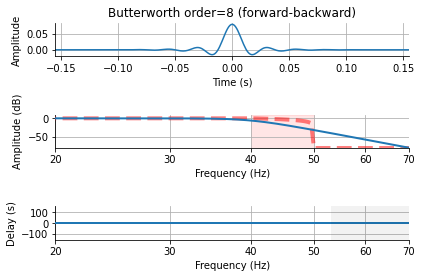

In [ ]:
iir_params = dict(order=8, ftype='butter')
filt = mne.filter.create_filter(x, sfreq, l_freq=None, h_freq=f_p,
                                method='iir', iir_params=iir_params,
                                verbose=True)
plot_filter(filt, sfreq, freq, gain, 'Butterworth order=8', flim=flim,
            compensate=True)
x_steep = signal.sosfiltfilt(filt['sos'], x)

There are other types of IIR filters that we can use. For a complete list,
check out the documentation for :func:`scipy.signal.iirdesign`. Let's
try a Chebychev (type I) filter, which trades off ripple in the pass-band
to get better attenuation in the stop-band:



Setting up low-pass filter at 40 Hz

IIR filter parameters
---------------------
Chebyshev I lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoff at 40.00 Hz: -2.00 dB



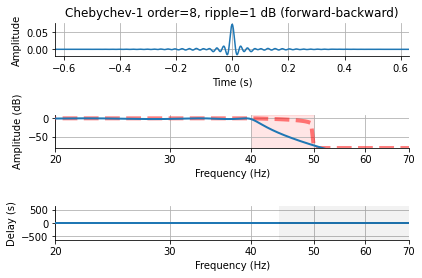

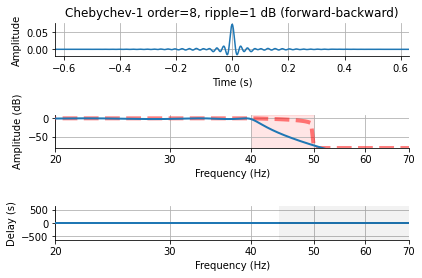

In [ ]:
iir_params.update(ftype='cheby1',
                  rp=1.,  # dB of acceptable pass-band ripple
                  )
filt = mne.filter.create_filter(x, sfreq, l_freq=None, h_freq=f_p,
                                method='iir', iir_params=iir_params,
                                verbose=True)
plot_filter(filt, sfreq, freq, gain,
            'Chebychev-1 order=8, ripple=1 dB', flim=flim, compensate=True)

If we can live with even more ripple, we can get it slightly steeper,
but the impulse response begins to ring substantially longer (note the
different x-axis scale):



Setting up low-pass filter at 40 Hz

IIR filter parameters
---------------------
Chebyshev I lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoff at 40.00 Hz: -12.00 dB



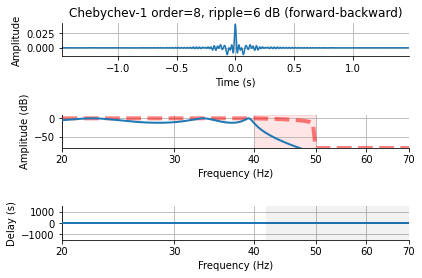

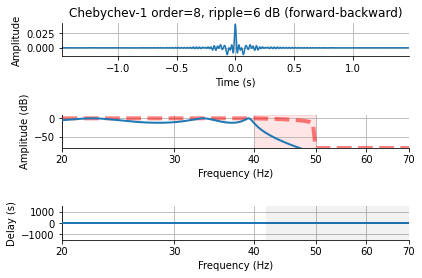

In [ ]:
iir_params['rp'] = 6.
filt = mne.filter.create_filter(x, sfreq, l_freq=None, h_freq=f_p,
                                method='iir', iir_params=iir_params,
                                verbose=True)
plot_filter(filt, sfreq, freq, gain,
            'Chebychev-1 order=8, ripple=6 dB', flim=flim,
            compensate=True)

### Applying IIR filters

Now let's look at how our shallow and steep Butterworth IIR filters
perform on our Morlet signal from before:



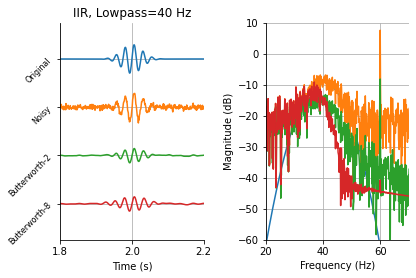

In [ ]:
axes = plt.subplots(1, 2)[1]
yticks = np.arange(4) / -30.
yticklabels = ['Original', 'Noisy', 'Butterworth-2', 'Butterworth-8']
plot_signal(x_orig, offset=yticks[0])
plot_signal(x, offset=yticks[1])
plot_signal(x_shallow, offset=yticks[2])
plot_signal(x_steep, offset=yticks[3])
axes[0].set(xlim=tlim, title='IIR, Lowpass=%d Hz' % f_p, xticks=tticks,
            ylim=[-0.125, 0.025], yticks=yticks, yticklabels=yticklabels,)
for text in axes[0].get_yticklabels():
    text.set(rotation=45, size=8)
axes[1].set(xlim=flim, ylim=(-60, 10), xlabel='Frequency (Hz)',
            ylabel='Magnitude (dB)')
mne.viz.adjust_axes(axes)
mne.viz.tight_layout()
plt.show()

## Some pitfalls of filtering

Multiple recent papers have noted potential risks of drawing
errant inferences due to misapplication of filters.

### Low-pass problems

Filters in general, especially those that are non-causal (zero-phase), can
make activity appear to occur earlier or later than it truly did. As
mentioned in VanRullen (2011) [3], investigations of commonly (at the time)
used low-pass filters created artifacts when they were applied to simulated
data. However, such deleterious effects were minimal in many real-world
examples in Rousselet (2012) [5].

Perhaps more revealing, it was noted in Widmann & Schröger (2012) [6] that
the problematic low-pass filters from VanRullen (2011) [3]:

   1. Used a least-squares design (like :func:`scipy.signal.firls`) that
      included "do-not-care" transition regions, which can lead to
      uncontrolled behavior.
   2. Had a filter length that was independent of the transition bandwidth,
      which can cause excessive ringing and signal distortion.


### High-pass problems

When it comes to high-pass filtering, using corner frequencies above 0.1 Hz
were found in Acunzo *et al.* (2012) [4] to:

> "... generate a systematic bias easily leading to misinterpretations of
neural activity.”

In a related paper, Widmann *et al.* (2015) [7] also came to suggest a
0.1 Hz highpass. More evidence followed in Tanner *et al.* (2015) [8] of
such distortions. Using data from language ERP studies of semantic and
syntactic processing (i.e., N400 and P600), using a high-pass above 0.3 Hz
caused significant effects to be introduced implausibly early when compared
to the unfiltered data. From this, the authors suggested the optimal
high-pass value for language processing to be 0.1 Hz.

We can recreate a problematic simulation from Tanner *et al.* (2015) [8]:

> "The simulated component is a single-cycle cosine wave with an amplitude
of 5µV [sic], onset of 500 ms poststimulus, and duration of 800 ms. The
simulated component was embedded in 20 s of zero values to avoid
filtering edge effects... Distortions [were] caused by 2 Hz low-pass
and high-pass filters... No visible distortion to the original
waveform [occurred] with 30 Hz low-pass and 0.01 Hz high-pass filters...
Filter frequencies correspond to the half-amplitude (-6 dB) cutoff
(12 dB/octave roll-off)."

<div class="alert alert-info"><h4>Note</h4><p>This simulated signal contains energy not just within the
          pass-band, but also within the transition and stop-bands -- perhaps
          most easily understood because the signal has a non-zero DC value,
          but also because it is a shifted cosine that has been
          *windowed* (here multiplied by a rectangular window), which
          makes the cosine and DC frequencies spread to other frequencies
          (multiplication in time is convolution in frequency, so multiplying
          by a rectangular window in the time domain means convolving a sinc
          function with the impulses at DC and the cosine frequency in the
          frequency domain).</p></div>




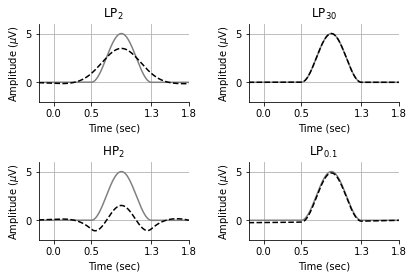

In [ ]:
x = np.zeros(int(2 * sfreq))
t = np.arange(0, len(x)) / sfreq - 0.2
onset = np.where(t >= 0.5)[0][0]
cos_t = np.arange(0, int(sfreq * 0.8)) / sfreq
sig = 2.5 - 2.5 * np.cos(2 * np.pi * (1. / 0.8) * cos_t)
x[onset:onset + len(sig)] = sig

iir_lp_30 = signal.iirfilter(2, 30. / sfreq, btype='lowpass')
iir_hp_p1 = signal.iirfilter(2, 0.1 / sfreq, btype='highpass')
iir_lp_2 = signal.iirfilter(2, 2. / sfreq, btype='lowpass')
iir_hp_2 = signal.iirfilter(2, 2. / sfreq, btype='highpass')
x_lp_30 = signal.filtfilt(iir_lp_30[0], iir_lp_30[1], x, padlen=0)
x_hp_p1 = signal.filtfilt(iir_hp_p1[0], iir_hp_p1[1], x, padlen=0)
x_lp_2 = signal.filtfilt(iir_lp_2[0], iir_lp_2[1], x, padlen=0)
x_hp_2 = signal.filtfilt(iir_hp_2[0], iir_hp_2[1], x, padlen=0)

xlim = t[[0, -1]]
ylim = [-2, 6]
xlabel = 'Time (sec)'
ylabel = r'Amplitude ($\mu$V)'
tticks = [0, 0.5, 1.3, t[-1]]
axes = plt.subplots(2, 2)[1].ravel()
for ax, x_f, title in zip(axes, [x_lp_2, x_lp_30, x_hp_2, x_hp_p1],
                          ['LP$_2$', 'LP$_{30}$', 'HP$_2$', 'LP$_{0.1}$']):
    ax.plot(t, x, color='0.5')
    ax.plot(t, x_f, color='k', linestyle='--')
    ax.set(ylim=ylim, xlim=xlim, xticks=tticks,
           title=title, xlabel=xlabel, ylabel=ylabel)
mne.viz.adjust_axes(axes)
mne.viz.tight_layout()
plt.show()

Similarly, in a P300 paradigm reported by Kappenman & Luck (2010) [12],
they found that applying a 1 Hz high-pass decreased the probability of
finding a significant difference in the N100 response, likely because
the P300 response was smeared (and inverted) in time by the high-pass
filter such that it tended to cancel out the increased N100. However,
they nonetheless note that some high-passing can still be useful to deal
with drifts in the data.

Even though these papers generally advise a 0.1 Hz or lower frequency for
a high-pass, it is important to keep in mind (as most authors note) that
filtering choices should depend on the frequency content of both the
signal(s) of interest and the noise to be suppressed. For example, in
some of the MNE-Python examples involving the `sample-dataset` dataset,
high-pass values of around 1 Hz are used when looking at auditory
or visual N100 responses, because we analyze standard (not deviant) trials
and thus expect that contamination by later or slower components will
be limited.

### Baseline problems (or solutions?)

In an evolving discussion, Tanner *et al.* (2015) [8] suggest using baseline
correction to remove slow drifts in data. However, Maess *et al.* (2016) [9]
suggest that baseline correction, which is a form of high-passing, does
not offer substantial advantages over standard high-pass filtering.
Tanner *et al.* (2016) [10] rebutted that baseline correction can correct
for problems with filtering.

To see what they mean, consider again our old simulated signal ``x`` from
before:



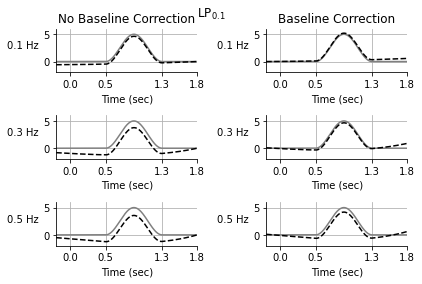

In [ ]:
def baseline_plot(x):
    all_axes = plt.subplots(3, 2)[1]
    for ri, (axes, freq) in enumerate(zip(all_axes, [0.1, 0.3, 0.5])):
        for ci, ax in enumerate(axes):
            if ci == 0:
                iir_hp = signal.iirfilter(4, freq / sfreq, btype='highpass',
                                          output='sos')
                x_hp = signal.sosfiltfilt(iir_hp, x, padlen=0)
            else:
                x_hp -= x_hp[t < 0].mean()
            ax.plot(t, x, color='0.5')
            ax.plot(t, x_hp, color='k', linestyle='--')
            if ri == 0:
                ax.set(title=('No ' if ci == 0 else '') +
                       'Baseline Correction')
            ax.set(xticks=tticks, ylim=ylim, xlim=xlim, xlabel=xlabel)
            ax.set_ylabel('%0.1f Hz' % freq, rotation=0,
                          horizontalalignment='right')
        mne.viz.adjust_axes(axes)
    mne.viz.tight_layout()
    plt.suptitle(title)
    plt.show()


baseline_plot(x)

In response, Maess *et al.* (2016) [11] note that these simulations do not
address cases of pre-stimulus activity that is shared across conditions, as
applying baseline correction will effectively copy the topology outside the
baseline period. We can see this if we give our signal ``x`` with some
consistent pre-stimulus activity, which makes everything look bad.

<div class="alert alert-info"><h4>Note</h4><p>An important thing to keep in mind with these plots is that they
          are for a single simulated sensor. In multi-electrode recordings
          the topology (i.e., spatial pattern) of the pre-stimulus activity
          will leak into the post-stimulus period. This will likely create a
          spatially varying distortion of the time-domain signals, as the
          averaged pre-stimulus spatial pattern gets subtracted from the
          sensor time courses.</p></div>

Putting some activity in the baseline period:



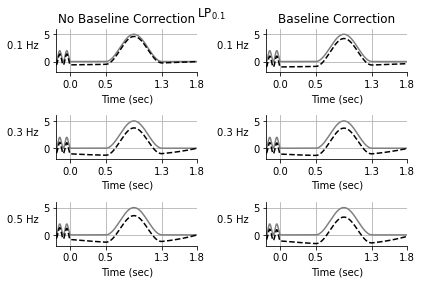

In [ ]:
n_pre = (t < 0).sum()
sig_pre = 1 - np.cos(2 * np.pi * np.arange(n_pre) / (0.5 * n_pre))
x[:n_pre] += sig_pre
baseline_plot(x)

Both groups seem to acknowledge that the choices of filtering cutoffs, and
perhaps even the application of baseline correction, depend on the
characteristics of the data being investigated, especially when it comes to:

   1. The frequency content of the underlying evoked activity relative
      to the filtering parameters.
   2. The validity of the assumption of no consistent evoked activity
      in the baseline period.

We thus recommend carefully applying baseline correction and/or high-pass
values based on the characteristics of the data to be analyzed.


## Filtering defaults


### Defaults in MNE-Python

Most often, filtering in MNE-Python is done at the :class:`mne.io.Raw` level,
and thus :func:`mne.io.Raw.filter` is used. This function under the hood
(among other things) calls :func:`mne.filter.filter_data` to actually
filter the data, which by default applies a zero-phase FIR filter designed
using :func:`scipy.signal.firwin`. In Widmann *et al.* (2015) [7], they
suggest a specific set of parameters to use for high-pass filtering,
including:

> "... providing a transition bandwidth of 25% of the lower passband
edge but, where possible, not lower than 2 Hz and otherwise the
distance from the passband edge to the critical frequency.”

In practice, this means that for each high-pass value ``l_freq`` or
low-pass value ``h_freq`` below, you would get this corresponding
``l_trans_bandwidth`` or ``h_trans_bandwidth``, respectively,
if the sample rate were 100 Hz (i.e., Nyquist frequency of 50 Hz):


| l_freq or h_freq | l_trans_bandwidth | h_trans_bandwidth |
|----|---|---|
|             0.01 |              0.01 |               2.0 |
|              0.1 |               0.1 |               2.0 |
|              1.0 |               1.0 |               2.0 |
|              2.0 |               2.0 |               2.0 |
|              4.0 |               2.0 |               2.0 |
|              8.0 |               2.0 |               2.0 |
|             10.0 |               2.5 |               2.5 |
|             20.0 |               5.0 |               5.0 |
|             40.0 |              10.0 |              10.0 |
|             50.0 |              12.5 |              12.5 |

MNE-Python has adopted this definition for its high-pass (and low-pass)
transition bandwidth choices when using ``l_trans_bandwidth='auto'`` and
``h_trans_bandwidth='auto'``.

To choose the filter length automatically with ``filter_length='auto'``,
the reciprocal of the shortest transition bandwidth is used to ensure
decent attenuation at the stop frequency. Specifically, the reciprocal
(in samples) is multiplied by 3.1, 3.3, or 5.0 for the Hann, Hamming,
or Blackman windows, respectively, as selected by the ``fir_window``
argument for ``fir_design='firwin'``, and double these for
``fir_design='firwin2'`` mode.

<div class="alert alert-info"><h4>Note</h4><p>For ``fir_design='firwin2'``, the multiplicative factors are
          doubled compared to what is given in Ifeachor & Jervis (2002) [2]
          (p. 357), as :func:`scipy.signal.firwin2` has a smearing effect
          on the frequency response, which we compensate for by
          increasing the filter length. This is why
          ``fir_desgin='firwin'`` is preferred to ``fir_design='firwin2'``.</p></div>

In 0.14, we default to using a Hamming window in filter design, as it
provides up to 53 dB of stop-band attenuation with small pass-band ripple.

<div class="alert alert-info"><h4>Note</h4><p>In band-pass applications, often a low-pass filter can operate
          effectively with fewer samples than the high-pass filter, so
          it is advisable to apply the high-pass and low-pass separately
          when using ``fir_design='firwin2'``. For design mode
          ``fir_design='firwin'``, there is no need to separate the
          operations, as the lowpass and highpass elements are constructed
          separately to meet the transition band requirements.</p></div>

For more information on how to use the
MNE-Python filtering functions with real data, consult the preprocessing
tutorial on `tut-filter-resample`.

### Defaults in MNE-C
MNE-C by default uses:

   1. 5 Hz transition band for low-pass filters.
   2. 3-sample transition band for high-pass filters.
   3. Filter length of 8197 samples.

The filter is designed in the frequency domain, creating a linear-phase
filter such that the delay is compensated for as is done with the MNE-Python
``phase='zero'`` filtering option.

Squared-cosine ramps are used in the transition regions. Because these
are used in place of more gradual (e.g., linear) transitions,
a given transition width will result in more temporal ringing but also more
rapid attenuation than the same transition width in windowed FIR designs.

The default filter length will generally have excellent attenuation
but long ringing for the sample rates typically encountered in M/EEG data
(e.g. 500-2000 Hz).

### Defaults in other software
A good but possibly outdated comparison of filtering in various software
packages is available in Widmann *et al.* (2015) [7]. Briefly:

* EEGLAB
    MNE-Python 0.14 defaults to behavior very similar to that of EEGLAB
    (see the `EEGLAB filtering FAQ`_ for more information).
* FieldTrip
    By default FieldTrip applies a forward-backward Butterworth IIR filter
    of order 4 (band-pass and band-stop filters) or 2 (for low-pass and
    high-pass filters). Similar filters can be achieved in MNE-Python when
    filtering with :meth:`raw.filter(..., method='iir') <mne.io.Raw.filter>`
    (see also :func:`mne.filter.construct_iir_filter` for options).
    For more information, see e.g. the
    `FieldTrip band-pass documentation <ftbp_>`_.

## Reporting Filters
On page 45 in Widmann *et al.* (2015) [7], there is a convenient list of
important filter parameters that should be reported with each publication:

1. Filter type (high-pass, low-pass, band-pass, band-stop, FIR, IIR)
2. Cutoff frequency (including definition)
3. Filter order (or length)
4. Roll-off or transition bandwidth
5. Passband ripple and stopband attenuation
6. Filter delay (zero-phase, linear-phase, non-linear phase) and causality
7. Direction of computation (one-pass forward/reverse, or two-pass forward
   and reverse)

In the following, we will address how to deal with these parameters in MNE:


### Filter type
Depending on the function or method used, the filter type can be specified.
To name an example, in :func:`mne.filter.create_filter`, the relevant
arguments would be ``l_freq``, ``h_freq``, ``method``, and if the method is
FIR ``fir_window`` and ``fir_design``.


### Cutoff frequency
The cutoff of FIR filters in MNE is defined as half-amplitude cutoff in the
middle of the transition band. That is, if you construct a lowpass FIR filter
with ``h_freq = 40``, the filter function will provide a transition
bandwidth that depends on the ``h_trans_bandwidth`` argument. The desired
half-amplitude  cutoff of the lowpass FIR filter is then at
``h_freq + transition_bandwidth/2.``.

### Filter length (order) and transition bandwidth (roll-off)
In the `tut_filtering_in_python` section, we have already talked about
the default filter lengths and transition bandwidths that are used when no
custom values are specified using the respective filter function's arguments.

If you want to find out about the filter length and transition bandwidth that
were used through the 'auto' setting, you can use
:func:`mne.filter.create_filter` to print out the settings once more:



In [ ]:
# Use the same settings as when calling e.g., `raw.filter()`
fir_coefs = mne.filter.create_filter(
    data=None,  # data is only used for sanity checking, not strictly needed
    sfreq=1000.,  # sfreq of your data in Hz
    l_freq=None,
    h_freq=40.,  # assuming a lowpass of 40 Hz
    method='fir',
    fir_window='hamming',
    fir_design='firwin',
    verbose=True)

# See the printed log for the transition bandwidth and filter length.
# Alternatively, get the filter length through:
filter_length = fir_coefs.shape[0]

No data specified. Sanity checks related to the length of the signal relative to the filter order will be skipped.
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)



<div class="alert alert-info"><h4>Note</h4><p>If you are using an IIR filter, :func:`mne.filter.create_filter`
          will not print a filter length and transition bandwidth to the log.
          Instead, you can specify the roll-off with the ``iir_params``
          argument or stay with the default, which is a fourth order
          (Butterworth) filter.</p></div>

### Passband ripple and stopband attenuation

When use standard :func:`scipy.signal.firwin` design (as for FIR filters in
MNE), the passband ripple and stopband attenuation are dependent upon the
window used in design. For standard windows the values are listed in this
table (see Ifeachor & Jervis (2002) [2], p. 357):


| Name of window function | Passband ripple | Stopband attenuation |
|----|---|---|
| Hann                    | 0.0545 dB       | 44 dB                |
| Hamming                 | 0.0194 dB       | 53 dB                |
| Blackman                | 0.0017 dB       | 74 dB                |



### Filter delay and direction of computation
For reporting this information, it might be sufficient to read the docstring
of the filter function or method that you apply. For example in the
docstring of `mne.filter.create_filter`, for the phase parameter it says:

> Phase of the filter, only used if ``method='fir'``.
By default, a symmetric linear-phase FIR filter is constructed.
If ``phase='zero'`` (default), the delay of this filter
is compensated for. If ``phase=='zero-double'``, then this filter
is applied twice, once forward, and once backward. If 'minimum',
then a minimum-phase, causal filter will be used.


## Summary

When filtering, there are always trade-offs that should be considered.
One important trade-off is between time-domain characteristics (like ringing)
and frequency-domain attenuation characteristics (like effective transition
bandwidth). Filters with sharp frequency cutoffs can produce outputs that
ring for a long time when they operate on signals with frequency content
in the transition band. In general, therefore, the wider a transition band
that can be tolerated, the better behaved the filter will be in the time
domain.

## References



[1] Parks TW, Burrus CS (1987). Digital Filter Design.
       New York: Wiley-Interscience.

[2] Ifeachor, E. C., & Jervis, B. W. (2002). Digital Signal Processing:
       A Practical Approach. Prentice Hall.

[3] Vanrullen, R. (2011). Four common conceptual fallacies in mapping
       the time course of recognition. Perception Science, 2, 365.

[4] Acunzo, D. J., MacKenzie, G., & van Rossum, M. C. W. (2012).
       Systematic biases in early ERP and ERF components as a result
       of high-pass filtering. Journal of Neuroscience Methods,
       209(1), 212–218. https://doi.org/10.1016/j.jneumeth.2012.06.011

[5] Rousselet, G. A. (2012). Does filtering preclude us from studying
       ERP time-courses? Frontiers in Psychology, 3(131)

[6] Widmann, A., & Schröger, E. (2012). Filter effects and filter
       artifacts in the analysis of electrophysiological data.
       Perception Science, 233.

[7] Widmann, A., Schröger, E., & Maess, B. (2015). Digital filter
       design for electrophysiological data – a practical approach.
       Journal of Neuroscience Methods, 250, 34–46.
       https://doi.org/10.1016/j.jneumeth.2014.08.002

[8] Tanner, D., Morgan-Short, K., & Luck, S. J. (2015).
       How inappropriate high-pass filters can produce artifactual effects
       and incorrect conclusions in ERP studies of language and cognition.
       Psychophysiology, 52(8), 997–1009. https://doi.org/10.1111/psyp.12437
.. [9] Maess, B., Schröger, E., & Widmann, A. (2016).
       High-pass filters and baseline correction in M/EEG analysis.
       Commentary on: “How inappropriate high-pass filters can produce
       artifacts and incorrect conclusions in ERP studies of language
       and cognition.” Journal of Neuroscience Methods, 266, 164–165.

[10] Tanner, D., Norton, J. J. S., Morgan-Short, K., & Luck, S. J. (2016).
       On high-pass filter artifacts (they’re real) and baseline correction
       (it’s a good idea) in ERP/ERMF analysis.

[11] Maess, B., Schröger, E., & Widmann, A. (2016).
       High-pass filters and baseline correction in M/EEG analysis-continued
       discussion. Journal of Neuroscience Methods, 266, 171–172.
       Journal of Neuroscience Methods, 266, 166–170.


[12] Kappenman E. & Luck, S. (2010). The effects of impedance on data
       quality and statistical significance in ERP recordings.
       Psychophysiology, 47, 888-904.


